Device being used: cpu
Loading and preprocessing now...
Building the CNN Model...

Training baseline model...
Epoch 1/10, Train Loss: 0.4890, Val Loss: 0.3389, Val Accuracy: 0.8769
Epoch 2/10, Train Loss: 0.3089, Val Loss: 0.2984, Val Accuracy: 0.8941
Epoch 3/10, Train Loss: 0.2645, Val Loss: 0.2763, Val Accuracy: 0.8992
Epoch 4/10, Train Loss: 0.2337, Val Loss: 0.2627, Val Accuracy: 0.9037
Epoch 5/10, Train Loss: 0.2125, Val Loss: 0.2355, Val Accuracy: 0.9133
Epoch 6/10, Train Loss: 0.1913, Val Loss: 0.2280, Val Accuracy: 0.9160
Epoch 7/10, Train Loss: 0.1718, Val Loss: 0.2318, Val Accuracy: 0.9199
Epoch 8/10, Train Loss: 0.1510, Val Loss: 0.2560, Val Accuracy: 0.9083
Epoch 9/10, Train Loss: 0.1359, Val Loss: 0.2462, Val Accuracy: 0.9152
Epoch 10/10, Train Loss: 0.1202, Val Loss: 0.2445, Val Accuracy: 0.9189


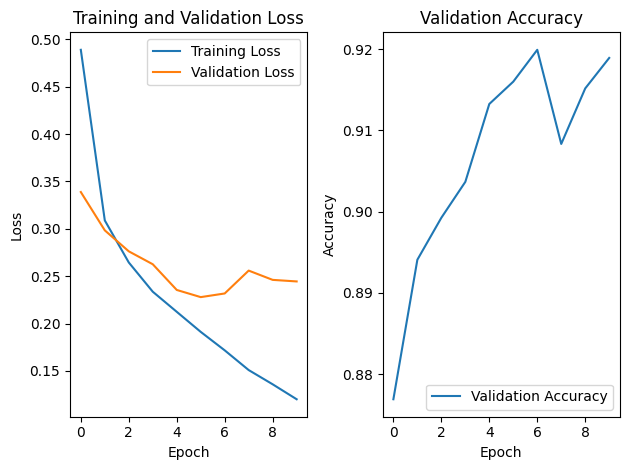


Evaluate baseline model on test data:
Test Accuracy: 0.9117


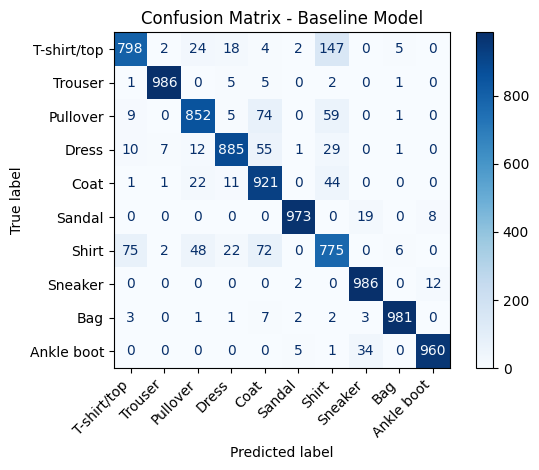


Creating and training Improved Model 1 (with Dropout and BatchNorm)...
Epoch 1/10, Train Loss: 0.4939, Val Loss: 0.3248, Val Accuracy: 0.8812
Epoch 2/10, Train Loss: 0.3552, Val Loss: 0.2737, Val Accuracy: 0.9004
Epoch 3/10, Train Loss: 0.3180, Val Loss: 0.2471, Val Accuracy: 0.9100
Epoch 4/10, Train Loss: 0.2949, Val Loss: 0.2860, Val Accuracy: 0.8902
Epoch 5/10, Train Loss: 0.2755, Val Loss: 0.2297, Val Accuracy: 0.9163
Epoch 6/10, Train Loss: 0.2681, Val Loss: 0.2350, Val Accuracy: 0.9161
Epoch 7/10, Train Loss: 0.2550, Val Loss: 0.2231, Val Accuracy: 0.9189
Epoch 8/10, Train Loss: 0.2457, Val Loss: 0.2205, Val Accuracy: 0.9207
Epoch 9/10, Train Loss: 0.2420, Val Loss: 0.2175, Val Accuracy: 0.9217
Epoch 10/10, Train Loss: 0.2317, Val Loss: 0.2184, Val Accuracy: 0.9233

Creating and training Improved Model 2 (Deeper Architecture with added layers)...
Epoch 1/10, Train Loss: 0.4813, Val Loss: 0.3169, Val Accuracy: 0.8828
Epoch 2/10, Train Loss: 0.2830, Val Loss: 0.2700, Val Accuracy:

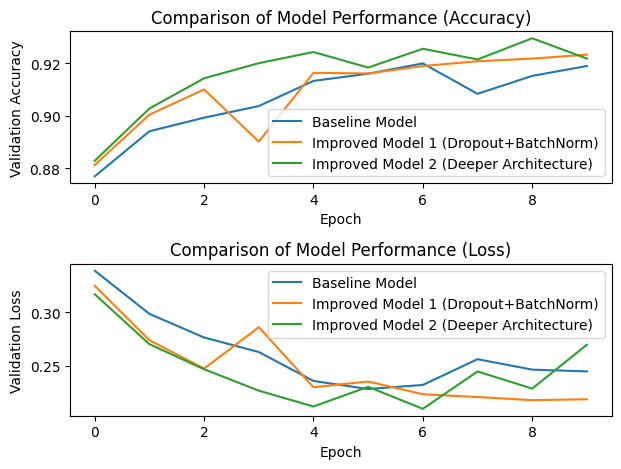

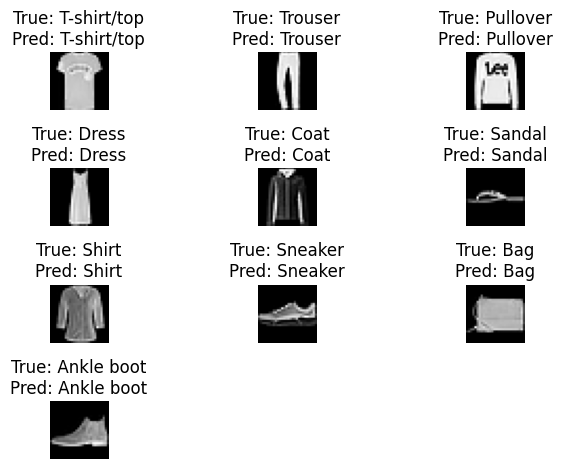

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Set seed so we can reproduce results
torch.manual_seed(42)

#Selects computational device that PyTorch will use for tensor operations and NN training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device being used: {device}")

# Part 1: Data Preprocessing
print("Loading and preprocessing now...")

# Normalize images to range [0,1]
transform = transforms.Compose([transforms.ToTensor()])

# Load training data
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Load test data
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# Split training data into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

# Class names 
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Part 2: Building the CNN Model
class BaseCNN(nn.Module):
    def __init__(self):
        super(BaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu3 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        return x

# Create the model
print("Building the CNN Model...")
model = BaseCNN().to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Part 3: Training & Evaluation
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)

        # Calc Epoch Stats
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation Loop
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                running_loss += loss.item() * inputs.size(0)
                
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calc Validation Stats
        epoch_val_loss = running_loss / len(val_loader.dataset)
        val_losses.append(epoch_val_loss)
        
        val_accuracy = correct / total
        val_accuracies.append(val_accuracy)

        # Progress report so I can see it working in real time
        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Val Loss: {epoch_val_loss:.4f}, '
              f'Val Accuracy: {val_accuracy:.4f}')
    
    return train_losses, val_losses, val_accuracies

# Train the model
print(f"\nTraining baseline model...")
train_losses, val_losses, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=10
)

# Plot training and validation loss curves
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    # Eval Loop, calcualtes the predicted class for each image and counts/stores correct predictions
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate and return our results
    test_accuracy = correct / total
    print(f'Test Accuracy: {test_accuracy:.4f}')
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    return test_accuracy, cm, all_preds, all_labels

# Evaluate the model
print("\nEvaluate baseline model on test data:")
test_accuracy, cm, all_preds, all_labels = evaluate_model(model, test_loader)

# Show confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Baseline Model')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Part 4: Experimentation & Improvements
# Improvement 1: Adding Dropout and Batch Normalization
class ImprovedCNN1(nn.Module):
    def __init__(self):
        super(ImprovedCNN1, self).__init__()
        # First convolutional block with 1 input channel, 32 output channels
        # Use ReLU activation function to introduce non-linearity
        # Max pooling with 2 by 2 kernel to reduce spatial dim
        # Dropout randomly zeroes 25% of the elements during training to stop overfitting
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.dropout1 = nn.Dropout(0.25)

        #Second Convolutional Block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.dropout2 = nn.Dropout(0.25)

        #Fully connected layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        
        self.fc2 = nn.Linear(128, 10)

    #Defines the dataflow through the network for each block
    def forward(self, x):
        x = self.pool1(self.relu1(self.bn1(self.conv1(x))))
        x = self.dropout1(x)
        
        x = self.pool2(self.relu2(self.bn2(self.conv2(x))))
        x = self.dropout2(x)
        
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout3(self.relu3(self.bn3(self.fc1(x))))
        x = self.fc2(x)
        return x

# Improvement 2: Deeper Architecture AKA Adding more layers
class ImprovedCNN2(nn.Module):
    def __init__(self):
        super(ImprovedCNN2, self).__init__()
        #First convolutional block
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)

        #Second Convolutional Block
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.relu3 = nn.ReLU()
        
        self.conv4 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.relu4 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)

        #Fully Connected Layers
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.relu5 = nn.ReLU()
        
        self.fc2 = nn.Linear(128, 10)

    #Forward method shows the data flow through the network for each block
    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(self.relu2(self.conv2(x)))
        
        x = self.relu3(self.conv3(x))
        x = self.pool2(self.relu4(self.conv4(x)))
        
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu5(self.fc1(x))
        x = self.fc2(x)
        return x

# Create and train improved models
print("\nCreating and training Improved Model 1 (with Dropout and BatchNorm)...")
improved_model1 = ImprovedCNN1().to(device)
improved_optimizer1 = optim.Adam(improved_model1.parameters(), lr=0.001)

improved_train_losses1, improved_val_losses1, improved_val_accuracies1 = train_model(
    improved_model1, train_loader, val_loader, criterion, improved_optimizer1, num_epochs=10
)

print("\nCreating and training Improved Model 2 (Deeper Architecture with added layers)...")
improved_model2 = ImprovedCNN2().to(device)
improved_optimizer2 = optim.Adam(improved_model2.parameters(), lr=0.001)

improved_train_losses2, improved_val_losses2, improved_val_accuracies2 = train_model(
    improved_model2, train_loader, val_loader, criterion, improved_optimizer2, num_epochs=10
)

# Evaluate improved models
print("\nEvaluating Improved Model 1...")
improved_test_accuracy1, improved_cm1, _, _ = evaluate_model(improved_model1, test_loader)

print("\nEvaluating Improved Model 2...")
improved_test_accuracy2, improved_cm2, _, _ = evaluate_model(improved_model2, test_loader)

# Compare results
print("\n------- Compare Results -------")
print(f"Baseline Model Test Accuracy: {test_accuracy:.4f}")
print(f"Improved Model 1 (Dropout+BatchNorm) Test Accuracy: {improved_test_accuracy1:.4f}")
print(f"Improved Model 2 (Deeper Architecture/More Layers) Test Accuracy: {improved_test_accuracy2:.4f}")

# Plot comparison of validation accuracies
plt.subplot(2, 1, 1)
plt.plot(val_accuracies, label='Baseline Model')
plt.plot(improved_val_accuracies1, label='Improved Model 1 (Dropout+BatchNorm)')
plt.plot(improved_val_accuracies2, label='Improved Model 2 (Deeper Architecture)')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Comparison of Model Performance (Accuracy)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(val_losses, label='Baseline Model')
plt.plot(improved_val_losses1, label='Improved Model 1 (Dropout+BatchNorm)')
plt.plot(improved_val_losses2, label='Improved Model 2 (Deeper Architecture)')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.title('Comparison of Model Performance (Loss)')
plt.legend()

plt.tight_layout()
plt.show()

# Save one example of each class from the test set with its prediction
num_classes = 10
num_examples = min(num_classes, 10)  # Display one example for each class

examples_by_class = {}

# Collect examples for each class
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        for i in range(len(labels)):
            true_label = labels[i].item()
            pred_label = preds[i].item()
            
            if true_label not in examples_by_class:
                examples_by_class[true_label] = (images[i].cpu(), pred_label)
                
        if len(examples_by_class) == num_classes:
            break

# Plot examples
for i, class_idx in enumerate(range(num_examples)):
    if class_idx in examples_by_class:
        img, pred = examples_by_class[class_idx]
        plt.subplot(4, 3, i + 1)
        plt.imshow(img.squeeze(), cmap='gray')
        plt.title(f"True: {class_names[class_idx]}\nPred: {class_names[pred]}")
        plt.axis('off')

plt.tight_layout()
plt.show()